## KING COUNTY HOUSE PRICE PREDICTION

## Final Project Submission

Please fill out:
* Student name:
* Student pace: full time
* Scheduled project review date/time:
* Instructor name:
* Blog post URL:


# Overview
This project investigates the factors affecting prices of houses in King County, Washington.




# Business Understanding
To identify how house prices are affected by various factors and to provide a guide on how to best identify properties that bear a high resell value for to maximize on profit margins.

# Background
King County has witnessed a vibrant real estate market.The housing market in this county is competitive, and homeowners looking to buy or sell properties frequently seek guidance from local real estate agencies. One common concern among homeowners is the potential value added by home renovations. This project aims to provide data-driven insights into this issue, helping homeowners make informed decisions on their properties. The King County House Sales dataset serves as a valuable resource for this analysis.

## Data Exploration

### Importing Libraries

#### Importing the relevant modules and the dataset

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm

#### Loading the dataset using pandas

In [ ]:
# Loading the data
df = pd.read_csv('data/kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


The dataset contains 21597 rows and 21 columns. Each row of the dataset contains information about one house.

Our objective is to find a way to estimate the value in the "price" column using the values in the other columns. By achieving this using this set of data, then we should able to estimate prices of other houses too, simply by asking for information like bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade','sqft_above', 'sqft_basement' etc

### Data Understanding

In [ ]:
#Obtaining the statistical summary of the data set
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,21597.0,4.580474e+09,2.876736e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21597.0,5.402966e+05,3.673681e+05,7.800000e+04,3.220000e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21597.0,3.373200e+00,9.262989e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21597.0,2.115826e+00,7.689843e-01,5.000000e-01,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21597.0,2.080322e+03,9.181061e+02,3.700000e+02,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21597.0,1.509941e+04,4.141264e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068500e+04,1.651359e+06
floors,21597.0,1.494096e+00,5.396828e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
sqft_above,21597.0,1.788597e+03,8.277598e+02,3.700000e+02,1.190000e+03,1.560000e+03,2.210000e+03,9.410000e+03
yr_built,21597.0,1.971000e+03,2.937523e+01,1.900000e+03,1.951000e+03,1.975000e+03,1.997000e+03,2.015000e+03
yr_renovated,17755.0,8.363678e+01,3.999464e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015000e+03


In [ ]:
# Get more infomation on the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [ ]:
#Checking for missing values
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### Data Cleaning / Preparation

Data preparation is the process of cleaning and transforming raw data prior to processing and analysis

In [ ]:
df_cleaned = df.drop(['id','date','view','sqft_living15','sqft_lot15','sqft_basement',"sqft_above",'yr_renovated'], axis = 1)
df_cleaned

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long
0,221900.0,3,1.00,1180,5650,1.0,NaN,Average,7 Average,1955,98178,47.5112,-122.257
1,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,NO,Average,8 Good,2009,98103,47.6993,-122.346
21593,400000.0,4,2.50,2310,5813,2.0,NO,Average,8 Good,2014,98146,47.5107,-122.362
21594,402101.0,2,0.75,1020,1350,2.0,NO,Average,7 Average,2009,98144,47.5944,-122.299
21595,400000.0,3,2.50,1600,2388,2.0,NaN,Average,8 Good,2004,98027,47.5345,-122.069


The dropped columns are not necessary in our analysis.

In [ ]:
#Checking information of te dataset
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   waterfront   19221 non-null  object 
 7   condition    21597 non-null  object 
 8   grade        21597 non-null  object 
 9   yr_built     21597 non-null  int64  
 10  zipcode      21597 non-null  int64  
 11  lat          21597 non-null  float64
 12  long         21597 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 2.1+ MB


In [ ]:
#checking for null values in cleaned dataset
df_cleaned.isnull().sum()

price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
zipcode           0
lat               0
long              0
dtype: int64

In [ ]:
# Removing null values for the dataset
df_cleaned = df_cleaned.dropna()
df_cleaned

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long
1,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987,98074,47.6168,-122.045
5,1230000.0,4,4.50,5420,101930,1.0,NO,Average,11 Excellent,2001,98053,47.6561,-122.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.0,3,2.50,1310,1294,2.0,NO,Average,8 Good,2008,98116,47.5773,-122.409
21592,360000.0,3,2.50,1530,1131,3.0,NO,Average,8 Good,2009,98103,47.6993,-122.346
21593,400000.0,4,2.50,2310,5813,2.0,NO,Average,8 Good,2014,98146,47.5107,-122.362
21594,402101.0,2,0.75,1020,1350,2.0,NO,Average,7 Average,2009,98144,47.5944,-122.299


In [ ]:
#Checking for duplicates
df_cleaned.duplicated()

1        False
2        False
3        False
4        False
5        False
         ...  
21591    False
21592    False
21593    False
21594    False
21596    False
Length: 19221, dtype: bool

In [ ]:
for val in df_cleaned:
   print(df_cleaned[val].value_counts())
   print()

450000.0    153
350000.0    147
550000.0    144
500000.0    142
425000.0    135
           ... 
443750.0      1
204750.0      1
406550.0      1
278800.0      1
402101.0      1
Name: price, Length: 3391, dtype: int64

3     8721
4     6149
2     2451
5     1441
6      227
1      175
7       35
8       11
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

2.50    4839
1.00    3411
1.75    2725
2.25    1788
2.00    1722
1.50    1283
2.75    1038
3.00     662
3.50     656
3.25     521
3.75     136
4.00     121
4.50      91
4.25      73
0.75      65
4.75      22
5.00      17
5.25      11
5.50      10
1.25       8
6.00       6
0.50       4
5.75       3
6.75       2
8.00       2
6.25       2
7.50       1
7.75       1
6.50       1
Name: bathrooms, dtype: int64

1300    125
1440    121
1400    120
1820    118
1660    113
       ... 
2497      1
2331      1
1899      1
3316      1
1425      1
Name: sqft_living, Length: 992, dtype: int64

5000      329
6000      253
4000   

In [ ]:
# Spliting the grade column to a new column which only has the grade value in numbers.

df_cleaned.loc[:, 'grade'] = df_cleaned['grade'].str.split(' ').str[0]


C:\Users\HP\AppData\Local\Temp\ipykernel_15708\3008437868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, 'grade'] = df_cleaned['grade'].str.split(' ').str[0]


In [ ]:
#Changing the data type of grade from str to int
df_cleaned.loc[:, 'grade'] = df_cleaned['grade'].astype(np.int64)

C:\Users\HP\AppData\Local\Temp\ipykernel_15708\1190988431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, 'grade'] = df_cleaned['grade'].astype(np.int64)
C:\Users\HP\AppData\Local\Temp\ipykernel_15708\1190988431.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_cleaned.loc[:, 'grade'] = df_cleaned['grade'].astype(np.int64)


In [ ]:
# Changing  catergorical data in the condition column to numeric

# df_cleaned['condition'] = df_cleaned['condition'].map({'Poor':1, 'Fair':2, 'Average':3, 'Good':4, 'Very Good':5})
df_cleaned.loc[:,'condition'] = df_cleaned['condition'].map({'Poor':1, 'Fair':2, 'Average':3, 'Good':4, 'Very Good':5})
df_cleaned

C:\Users\HP\AppData\Local\Temp\ipykernel_15708\2847606290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,'condition'] = df_cleaned['condition'].map({'Poor':1, 'Fair':2, 'Average':3, 'Good':4, 'Very Good':5})
C:\Users\HP\AppData\Local\Temp\ipykernel_15708\2847606290.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_cleaned.loc[:,'condition'] = df_cleaned['condition'].map({'Poor':1, 'Fair':2, 'Average':3, 'Good':4, 'Very Good':5})


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,zipcode,lat,long
1,538000.0,3,2.25,2570,7242,2.0,NO,3,7,1951,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,NO,3,6,1933,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,NO,5,7,1965,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,NO,3,8,1987,98074,47.6168,-122.045
5,1230000.0,4,4.50,5420,101930,1.0,NO,3,11,2001,98053,47.6561,-122.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.0,3,2.50,1310,1294,2.0,NO,3,8,2008,98116,47.5773,-122.409
21592,360000.0,3,2.50,1530,1131,3.0,NO,3,8,2009,98103,47.6993,-122.346
21593,400000.0,4,2.50,2310,5813,2.0,NO,3,8,2014,98146,47.5107,-122.362
21594,402101.0,2,0.75,1020,1350,2.0,NO,3,7,2009,98144,47.5944,-122.299


In [ ]:
# From this we can tell the condition of most houses is average.
df_cleaned['condition'].value_counts()

3    12474
4     5058
5     1512
2      152
1       25
Name: condition, dtype: int64

In [ ]:
df_cleaned['waterfront'] = df['waterfront'].replace({'YES': 1, 'NO':0})
df_cleaned.loc[:, 'waterfront'] = df_cleaned['waterfront'].astype(np.int64)

C:\Users\HP\AppData\Local\Temp\ipykernel_15708\1139234438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['waterfront'] = df['waterfront'].replace({'YES': 1, 'NO':0})
C:\Users\HP\AppData\Local\Temp\ipykernel_15708\1139234438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, 'waterfront'] = df_cleaned['waterfront'].astype(np.int64)
C:\Users\HP\AppData\Local\Temp\ipykernel_15708\1139234438.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

This will now make it easier when carrying out statistical measurements.

In [ ]:
#Checking data information
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19221 entries, 1 to 21596
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        19221 non-null  float64
 1   bedrooms     19221 non-null  int64  
 2   bathrooms    19221 non-null  float64
 3   sqft_living  19221 non-null  int64  
 4   sqft_lot     19221 non-null  int64  
 5   floors       19221 non-null  float64
 6   waterfront   19221 non-null  int64  
 7   condition    19221 non-null  int64  
 8   grade        19221 non-null  int64  
 9   yr_built     19221 non-null  int64  
 10  zipcode      19221 non-null  int64  
 11  lat          19221 non-null  float64
 12  long         19221 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 2.1 MB


#### Data distribution

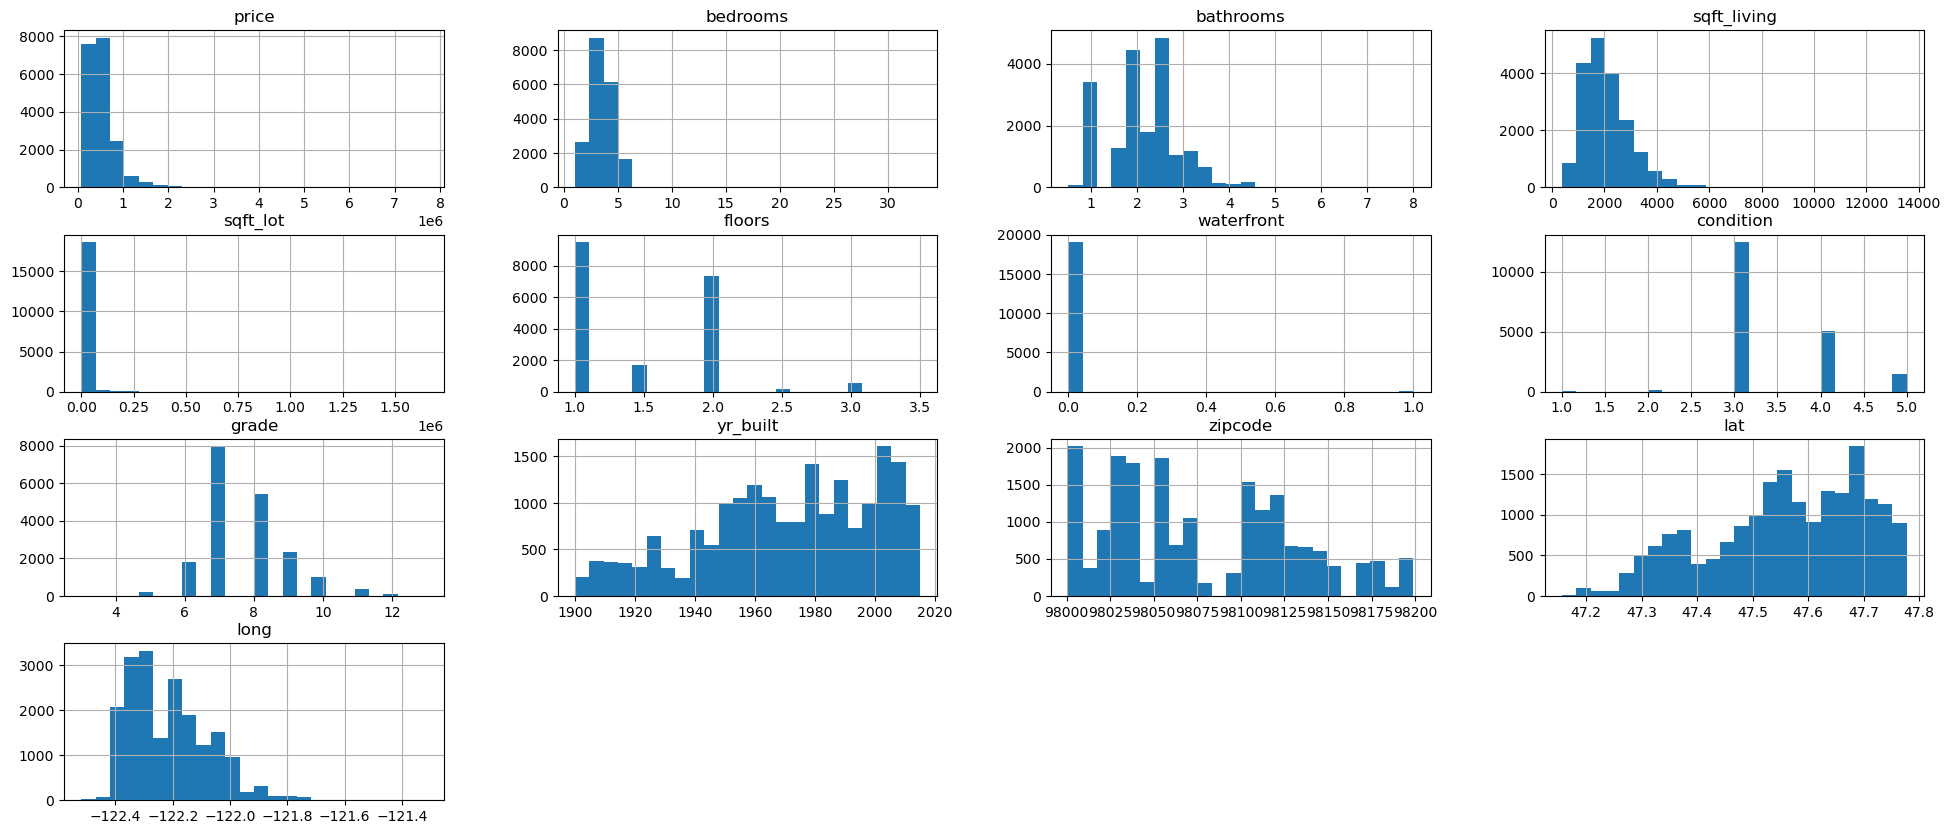

In [ ]:
# plotting histograms to visualize patterns in the data
df_cleaned.hist(figsize = (24,10), bins= 24)
plt.show()

##### Correlation Matrix
Using a heatmap to find out the correlation between the variables of this data set

In [ ]:
# Finding out the correlation between the features
df_cleaned.corr()['price']

price          1.000000
bedrooms       0.309651
bathrooms      0.527350
sqft_living    0.704652
sqft_lot       0.087005
floors         0.258277
waterfront     0.276295
condition      0.038037
grade          0.667224
yr_built       0.053525
zipcode       -0.050212
lat            0.305126
long           0.021390
Name: price, dtype: float64

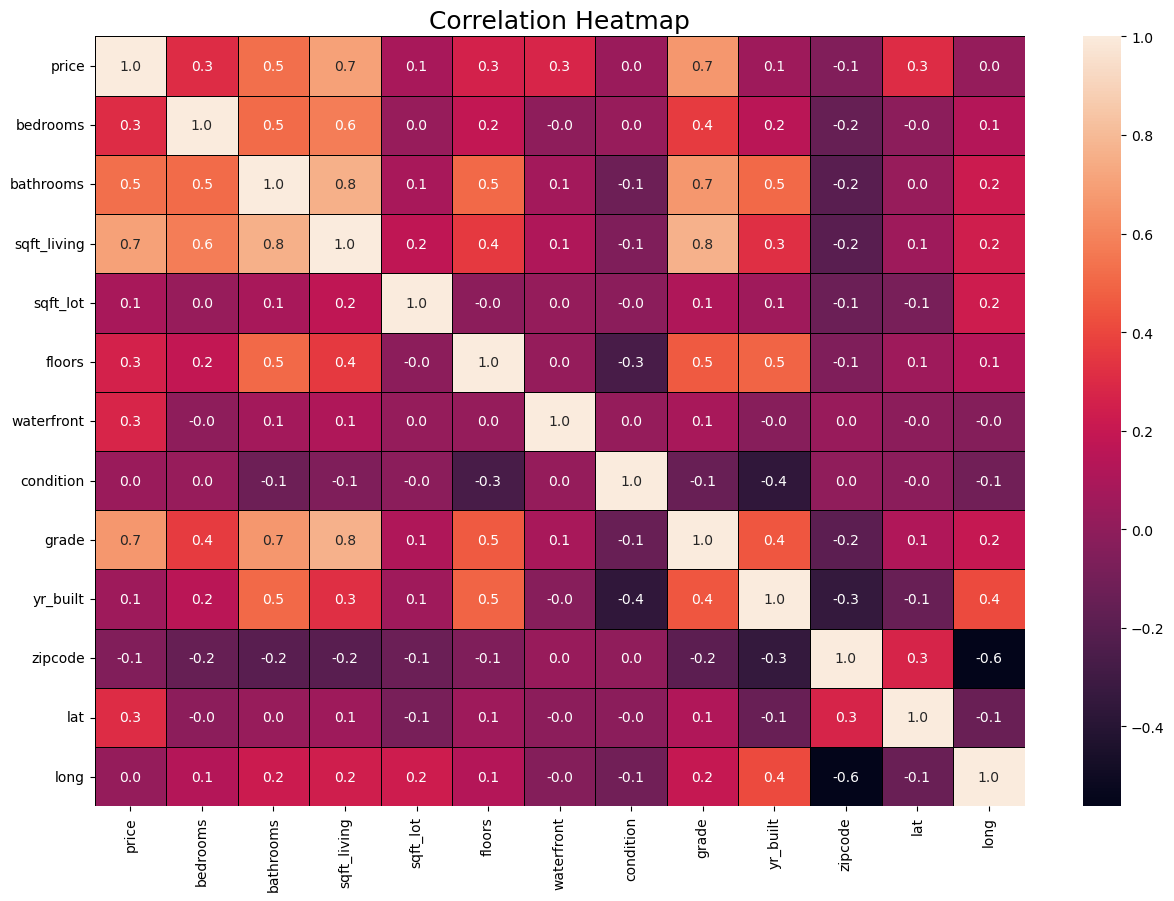

In [ ]:
# Plotting a correlation heatmap using seaborn. Border the squares with black color, show the correlation index and round it up.
plt.figure(figsize=(15, 10))  # Set the figure size
sns.heatmap(df_cleaned.corr(), annot=True, linewidths=0.5, linecolor='black', fmt='1.1f')

# Give a title to the map and display it.
plt.title('Correlation Heatmap', size=18)
plt.show()